# Image Classification using advanced CNNs
- we are going to use CIFAR-10 [dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 32x32 color images

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .9
# the number of epochs is the number of times you go through the full dataset
model_args['weight_decay'] = 5.e-4
model_args['epochs'] = 30
!rm -r ./data
# normalize dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
#mean = [.5, .5, .5]
#std = [.5, .5, .5]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(cifar10_train, [40000, 10000])
test_subset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_subset, range(5000))

# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')
def imshow(img):
    npimg = img.numpy()*std[0]+mean[0] # this should be done for each channel separately ;)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# get some random training images
dataiter = iter(train_loader)
images, _ = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:16], nrow=4))
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}
def train(model, device, train_loader, optimizer, criterion, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate loss using c
        loss = criterion(output, target)
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        train_loss += loss.item()
    print('Train Epoch: {}'.format(epoch_number))
    train_loss /= len(train_loader)
    print('\tTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, criterion, message=None):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += criterion(output, target) 
            # get the index of class with the max probability 
            prediction = output.argmax(dim=1)  
            #_, predicted = torch.max(outputs.data, axis=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    if message is not None:
        print('\t{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            message, test_loss, correct, len(test_loader.dataset), 100.*accuracy))
    return test_loss, accuracy

def run_training(model, criterion, optimizer, no_epochs):
    train_loss = []
    validation_loss = []
    validation_accuracy = []
    test_accuracy = []
    for epoch_number in range(1, no_epochs+1):
        train_loss.append(train(model, device, train_loader, 
                                optimizer, criterion, epoch_number))
        val_loss, val_acc = test(model, device, validation_loader, 
                                criterion, 'Validation set')
        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)
        # we also collect test accuracies fo every epoch
        _, test_acc = test(model, device, test_loader, criterion)
        test_accuracy.append(test_acc)
    # and select test accuracy for the best epoch (with the highest validation accuracy)
    best_accuracy = test_accuracy[np.argmax(validation_accuracy)]
    return train_loss, validation_loss, best_accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=model_args['weight_decay'])
no_epochs = model_args['epochs']

train_loss, val_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(torch.tensor(train_loss).cpu().numpy(), torch.tensor(val_loss).cpu().numpy(), 'SimpleCNN model')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=.5,
                      weight_decay=1.e-3)
no_epochs = model_args['epochs']

train_loss_11, val_loss_11, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_11, val_loss_11, 'VGG11 model')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg16'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']*2

train_loss_16, val_loss_16, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_16, val_loss_16, 'VGG16 model')
plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
plt.plot(range(1, len(train_loss_11)+1), train_loss_11, 'o-', label='train_VGG11')
plt.plot(range(1, len(val_loss_11)+1), val_loss_11, 'o-', label='val_VGG11')
plt.plot(range(1, len(train_loss_16)+1), train_loss_16, 'o-', label='train_VGG16')
plt.plot(range(1, len(val_loss_16)+1), val_loss_16, 'o-', label='val_VGG16')
plt.legend()
plt.title("VGGs comparison")
plt.show()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg19'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']*2
train_loss_19, val_loss_19, best_accuracy = run_training(model, criterion, optimizer, no_epochs)
print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
#plot_loss(train_loss_19, val_loss_19, 'VGG19 model')
plot_loss(torch.tensor(train_loss_19).cpu().numpy(), torch.tensor(val_loss_19).cpu().numpy(), 'VGG19 model')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg22'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']*2

train_loss_22, val_loss_22, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
#plot_loss(train_loss_22, val_loss_22, 'VGG22 model')
plot_loss(torch.tensor(train_loss_22).cpu().numpy(), torch.tensor(val_loss_22).cpu().numpy(), 'VGG22 model')
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']

train_loss, validation_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss, validation_loss, 'ResNet18 model')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet34().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']

train_loss34, validation_loss34, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
#plot_loss(train_loss34, validation_loss34, 'ResNet34 model')
plot_loss(torch.tensor(train_loss34).cpu().numpy(), torch.tensor(validation_loss34).cpu().numpy(), 'ResNet34 model')


### Download CIFAR-10 dataset and define models
Similar as with MNIST we use torchvision to download the data

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64 
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction) 
model_args['momentum'] = .9
# the number of epochs is the number of times you go through the full dataset
model_args['weight_decay'] = 5.e-4
model_args['epochs'] = 30

In [2]:
!rm -r ./data
# normalize dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
#mean = [.5, .5, .5]
#std = [.5, .5, .5]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(cifar10_train, [40000, 10000])
test_subset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_subset, range(5000))

# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

rm: cannot remove './data': No such file or directory


100%|██████████| 170498071/170498071 [00:02<00:00, 60522542.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's show some of the training images

In [3]:
def imshow(img):
    npimg = img.numpy()*std[0]+mean[0] # this should be done for each channel separately ;)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# get some random training images
dataiter = iter(train_loader)
images, _ = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:16], nrow=4))


AttributeError: ignored

Now define CNN models
- VGG definition borrowed from *https://github.com/chengyangfu/pytorch-vgg-cifar10*


In [4]:
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}

Define util methods

In [5]:
def train(model, device, train_loader, optimizer, criterion, epoch_number):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate loss using c
        loss = criterion(output, target)
        # backpropagate the loss
        loss.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        train_loss += loss.item()
    print('Train Epoch: {}'.format(epoch_number))
    train_loss /= len(train_loader)
    print('\tTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, criterion, message=None):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += criterion(output, target) 
            # get the index of class with the max probability 
            prediction = output.argmax(dim=1)  
            #_, predicted = torch.max(outputs.data, axis=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    if message is not None:
        print('\t{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            message, test_loss, correct, len(test_loader.dataset), 100.*accuracy))
    return test_loss, accuracy

def run_training(model, criterion, optimizer, no_epochs):
    train_loss = []
    validation_loss = []
    validation_accuracy = []
    test_accuracy = []
    for epoch_number in range(1, no_epochs+1):
        train_loss.append(train(model, device, train_loader, 
                                optimizer, criterion, epoch_number))
        val_loss, val_acc = test(model, device, validation_loader, 
                                criterion, 'Validation set')
        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)
        # we also collect test accuracies fo every epoch
        _, test_acc = test(model, device, test_loader, criterion)
        test_accuracy.append(test_acc)
    # and select test accuracy for the best epoch (with the highest validation accuracy)
    best_accuracy = test_accuracy[np.argmax(validation_accuracy)]
    return train_loss, validation_loss, best_accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

### Do the experiments

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=model_args['weight_decay'])
no_epochs = model_args['epochs']

train_loss, val_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(torch.tensor(train_loss).cpu().numpy(), torch.tensor(val_loss).cpu().numpy(), 'SimpleCNN model')



Train Epoch: 1
	Train set: Average loss: 1.8952
	Validation set: Average loss: 1.7076, Accuracy: 1798/5000 (36%)
Train Epoch: 2
	Train set: Average loss: 1.7015
	Validation set: Average loss: 1.6784, Accuracy: 1994/5000 (40%)
Train Epoch: 3
	Train set: Average loss: 1.5974
	Validation set: Average loss: 1.5941, Accuracy: 2111/5000 (42%)
Train Epoch: 4
	Train set: Average loss: 1.5591
	Validation set: Average loss: 1.6034, Accuracy: 2103/5000 (42%)
Train Epoch: 5
	Train set: Average loss: 1.4939
	Validation set: Average loss: 1.6235, Accuracy: 2149/5000 (43%)
Train Epoch: 6
	Train set: Average loss: 1.4828
	Validation set: Average loss: 1.4865, Accuracy: 2372/5000 (47%)
Train Epoch: 7
	Train set: Average loss: 1.4390
	Validation set: Average loss: 1.5257, Accuracy: 2307/5000 (46%)
Train Epoch: 8
	Train set: Average loss: 1.3878
	Validation set: Average loss: 1.4363, Accuracy: 2494/5000 (50%)
Train Epoch: 9
	Train set: Average loss: 1.3849
	Validation set: Average loss: 1.5128, Accuracy:

AttributeError: ignored

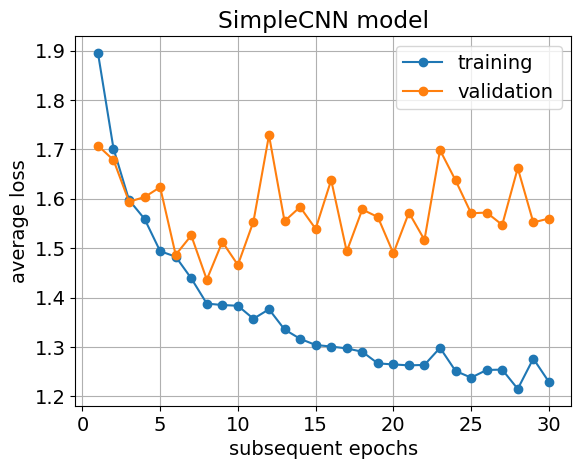

In [ ]:
plot_loss(torch.tensor(train_loss).cpu().numpy(), torch.tensor(val_loss).cpu().numpy(), 'SimpleCNN model')


Train Epoch: 1
	Train set: Average loss: 2.1554
	Validation set: Average loss: 2.0563, Accuracy: 1190/5000 (24%)
Train Epoch: 2
	Train set: Average loss: 1.8385
	Validation set: Average loss: 1.9248, Accuracy: 1466/5000 (29%)
Train Epoch: 3
	Train set: Average loss: 1.6179
	Validation set: Average loss: 1.5653, Accuracy: 2143/5000 (43%)
Train Epoch: 4
	Train set: Average loss: 1.4494
	Validation set: Average loss: 1.3321, Accuracy: 2565/5000 (51%)
Train Epoch: 5
	Train set: Average loss: 1.2908
	Validation set: Average loss: 1.2291, Accuracy: 2751/5000 (55%)
Train Epoch: 6
	Train set: Average loss: 1.1405
	Validation set: Average loss: 1.1619, Accuracy: 2896/5000 (58%)
Train Epoch: 7
	Train set: Average loss: 1.0159
	Validation set: Average loss: 1.2321, Accuracy: 2886/5000 (58%)
Train Epoch: 8
	Train set: Average loss: 0.9047
	Validation set: Average loss: 1.0665, Accuracy: 3200/5000 (64%)
Train Epoch: 9
	Train set: Average loss: 0.7850
	Validation set: Average loss: 0.9432, Accuracy:

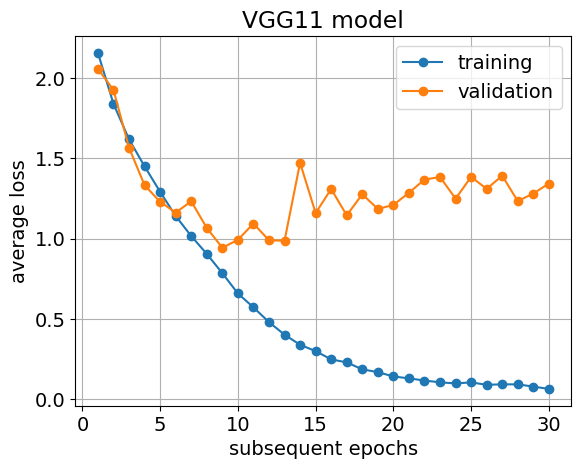

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=.5,
                      weight_decay=1.e-3)
no_epochs = model_args['epochs']

train_loss_11, val_loss_11, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
#plot_loss(train_loss_11, val_loss_11, 'VGG11 model')
plot_loss(torch.tensor(train_loss_11).cpu().numpy(), torch.tensor(val_loss_11).cpu().numpy(), 'VGG11 model')


Train Epoch: 1
	Train set: Average loss: 2.1786
	Validation set: Average loss: 2.0504, Accuracy: 1036/5000 (21%)
Train Epoch: 2
	Train set: Average loss: 1.8921
	Validation set: Average loss: 1.7177, Accuracy: 1688/5000 (34%)
Train Epoch: 3
	Train set: Average loss: 1.6918
	Validation set: Average loss: 1.5616, Accuracy: 1840/5000 (37%)
Train Epoch: 4
	Train set: Average loss: 1.5141
	Validation set: Average loss: 1.4671, Accuracy: 2348/5000 (47%)
Train Epoch: 5
	Train set: Average loss: 1.3919
	Validation set: Average loss: 1.4142, Accuracy: 2262/5000 (45%)
Train Epoch: 6
	Train set: Average loss: 1.2693
	Validation set: Average loss: 1.3025, Accuracy: 2714/5000 (54%)
Train Epoch: 7
	Train set: Average loss: 1.1707
	Validation set: Average loss: 1.1716, Accuracy: 2928/5000 (59%)
Train Epoch: 8
	Train set: Average loss: 1.0714
	Validation set: Average loss: 1.1377, Accuracy: 3025/5000 (60%)
Train Epoch: 9
	Train set: Average loss: 1.0367
	Validation set: Average loss: 1.2899, Accuracy:

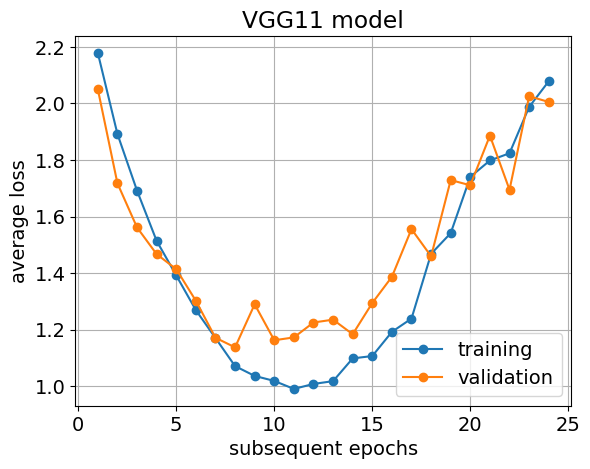

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg11'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=.9,
                      weight_decay=0)
no_epochs = model_args['epochs']

train_loss_11, val_loss_11, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
#plot_loss(train_loss_11, val_loss_11, 'VGG11 model')
plot_loss(torch.tensor(train_loss_11).cpu().numpy(), torch.tensor(val_loss_11).cpu().numpy(), 'VGG11 model with momentum=.9 and weight_decay=0')


Train Epoch: 1
	Train set: Average loss: 2.1951
	Validation set: Average loss: 2.0351, Accuracy: 1003/5000 (20%)
Train Epoch: 2
	Train set: Average loss: 1.9750
	Validation set: Average loss: 2.0061, Accuracy: 946/5000 (19%)
Train Epoch: 3
	Train set: Average loss: 1.9183
	Validation set: Average loss: 1.9809, Accuracy: 930/5000 (19%)
Train Epoch: 4
	Train set: Average loss: 1.8486
	Validation set: Average loss: 1.7544, Accuracy: 1524/5000 (30%)
Train Epoch: 5
	Train set: Average loss: 1.7407
	Validation set: Average loss: 1.6541, Accuracy: 1675/5000 (34%)
Train Epoch: 6
	Train set: Average loss: 1.6785
	Validation set: Average loss: 1.6786, Accuracy: 1682/5000 (34%)
Train Epoch: 7
	Train set: Average loss: 1.6191
	Validation set: Average loss: 1.5721, Accuracy: 1960/5000 (39%)
Train Epoch: 8
	Train set: Average loss: 1.5469
	Validation set: Average loss: 1.4330, Accuracy: 2264/5000 (45%)
Train Epoch: 9
	Train set: Average loss: 1.4635
	Validation set: Average loss: 1.4730, Accuracy: 2

TypeError: ignored

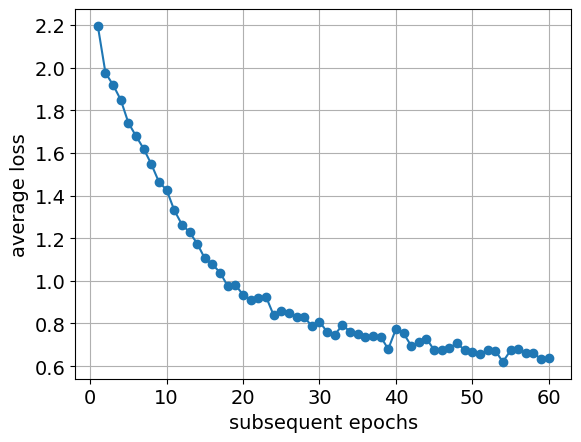

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg16'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']*2

train_loss_16, val_loss_16, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
#plot_loss(train_loss_16, val_loss_16, 'VGG16 model')
plot_loss(torch.tensor(train_loss_16).cpu().numpy(), torch.tensor(val_loss_16).cpu().numpy(), 'VGG16 model')

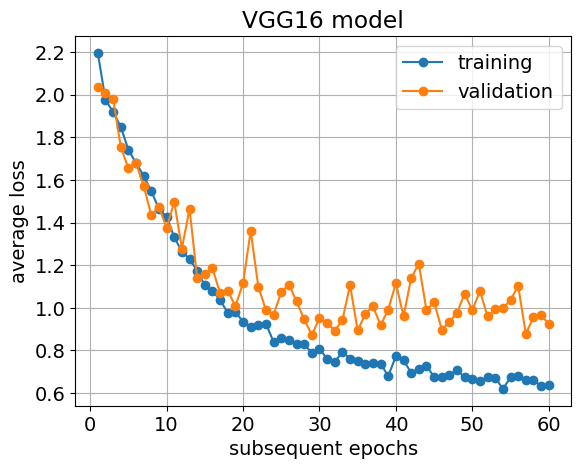

In [ ]:
plot_loss(torch.tensor(train_loss_16).cpu().numpy(), torch.tensor(val_loss_16).cpu().numpy(), 'VGG16 model')

Now compare training curves for both VGGs:

#Training VGG19 model.

Train Epoch: 1
	Train set: Average loss: 2.3024
	Validation set: Average loss: 2.3052, Accuracy: 476/5000 (10%)
Train Epoch: 2
	Train set: Average loss: 2.3044
	Validation set: Average loss: 2.3031, Accuracy: 503/5000 (10%)
Train Epoch: 3
	Train set: Average loss: 2.3045
	Validation set: Average loss: 2.3052, Accuracy: 476/5000 (10%)
Train Epoch: 4
	Train set: Average loss: 2.3050
	Validation set: Average loss: 2.3056, Accuracy: 476/5000 (10%)
Train Epoch: 5
	Train set: Average loss: 2.3041
	Validation set: Average loss: 2.3034, Accuracy: 501/5000 (10%)
Train Epoch: 6
	Train set: Average loss: 2.3041
	Validation set: Average loss: 2.3065, Accuracy: 462/5000 (9%)
Train Epoch: 7
	Train set: Average loss: 2.3041
	Validation set: Average loss: 2.3029, Accuracy: 530/5000 (11%)
Train Epoch: 8
	Train set: Average loss: 2.3047
	Validation set: Average loss: 2.3056, Accuracy: 462/5000 (9%)
Train Epoch: 9
	Train set: Average loss: 2.3044
	Validation set: Average loss: 2.3032, Accuracy: 501/5000 

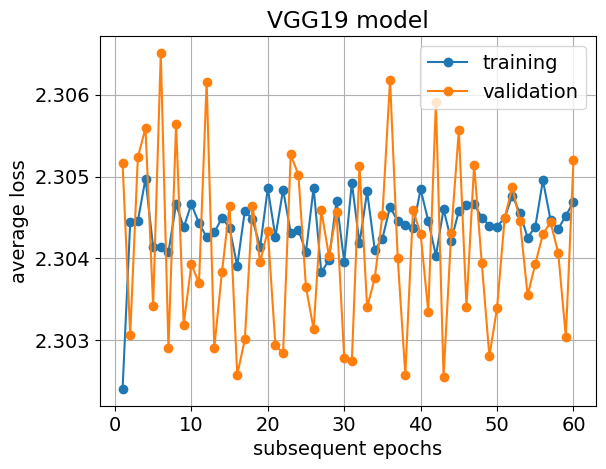

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg19'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']*2

train_loss_19, val_loss_19, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
#plot_loss(train_loss_19, val_loss_19, 'VGG19 model')
plot_loss(torch.tensor(train_loss_19).cpu().numpy(), torch.tensor(val_loss_19).cpu().numpy(), 'VGG19 model')

#training VGG22 model

Train Epoch: 1
	Train set: Average loss: 2.3023
	Validation set: Average loss: 2.3039, Accuracy: 500/5000 (10%)
Train Epoch: 2
	Train set: Average loss: 2.3048
	Validation set: Average loss: 2.3073, Accuracy: 476/5000 (10%)
Train Epoch: 3
	Train set: Average loss: 2.3042
	Validation set: Average loss: 2.3049, Accuracy: 530/5000 (11%)
Train Epoch: 4
	Train set: Average loss: 2.3048
	Validation set: Average loss: 2.3061, Accuracy: 476/5000 (10%)
Train Epoch: 5
	Train set: Average loss: 2.3040
	Validation set: Average loss: 2.3051, Accuracy: 476/5000 (10%)
Train Epoch: 6
	Train set: Average loss: 2.3049
	Validation set: Average loss: 2.3054, Accuracy: 476/5000 (10%)
Train Epoch: 7
	Train set: Average loss: 2.3044
	Validation set: Average loss: 2.3059, Accuracy: 501/5000 (10%)
Train Epoch: 8
	Train set: Average loss: 2.3042
	Validation set: Average loss: 2.3030, Accuracy: 478/5000 (10%)
Train Epoch: 9
	Train set: Average loss: 2.3047
	Validation set: Average loss: 2.3045, Accuracy: 503/500

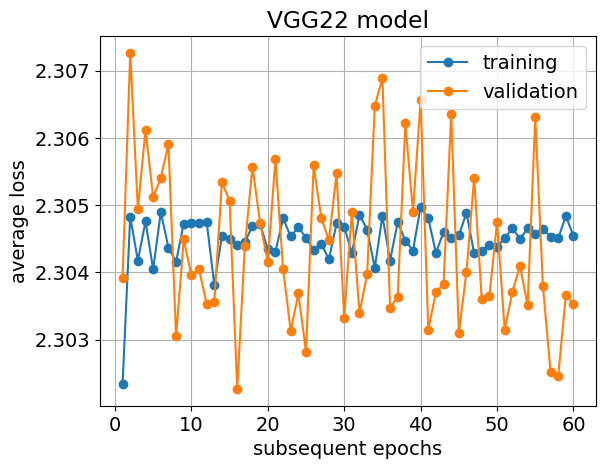

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG(make_layers(vgg_cfg['vgg22'])).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']*2

train_loss_22, val_loss_22, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
#plot_loss(train_loss_22, val_loss_22, 'VGG22 model')
plot_loss(torch.tensor(train_loss_22).cpu().numpy(), torch.tensor(val_loss_22).cpu().numpy(), 'VGG22 model')

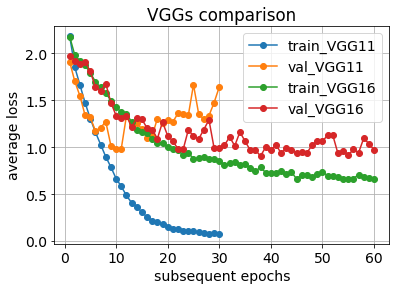

In [ ]:
plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
plt.plot(range(1, len(train_loss_11)+1), train_loss_11, 'o-', label='train_VGG11')
plt.plot(range(1, len(val_loss_11)+1), val_loss_11, 'o-', label='val_VGG11')
plt.plot(range(1, len(train_loss_16)+1), train_loss_16, 'o-', label='train_VGG16')
plt.plot(range(1, len(val_loss_16)+1), val_loss_16, 'o-', label='val_VGG16')
plt.legend()
plt.title("VGGs comparison")
plt.show()

Let's check residual network: ResNet
- implementarion borrowed from https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

# VGG199 and VGG22 comparison

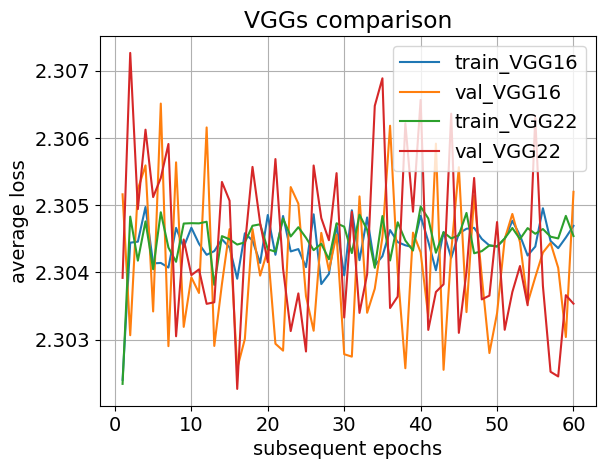

In [ ]:
plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
plt.plot(range(1, len(train_loss_19)+1), train_loss_19, label='train_VGG16')
plt.plot(range(1, len(val_loss_19)+1), torch.tensor(val_loss_19).cpu().numpy(), label='val_VGG16')
plt.plot(range(1, len(train_loss_22)+1), train_loss_22, label='train_VGG22')
plt.plot(range(1, len(val_loss_22)+1), torch.tensor(val_loss_22).cpu().numpy(), label='val_VGG22')
plt.legend()
plt.title("VGGs comparison")
plt.show()

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

Train Epoch: 1
	Train set: Average loss: 1.8744
	Validation set: Average loss: 1.5922, Accuracy: 2075/5000 (42%)
Train Epoch: 2
	Train set: Average loss: 1.4457
	Validation set: Average loss: 1.3260, Accuracy: 2550/5000 (51%)
Train Epoch: 3
	Train set: Average loss: 1.2511
	Validation set: Average loss: 1.2523, Accuracy: 2759/5000 (55%)
Train Epoch: 4
	Train set: Average loss: 1.0568
	Validation set: Average loss: 1.1678, Accuracy: 2916/5000 (58%)
Train Epoch: 5
	Train set: Average loss: 0.9113
	Validation set: Average loss: 1.0938, Accuracy: 3109/5000 (62%)
Train Epoch: 6
	Train set: Average loss: 0.7836
	Validation set: Average loss: 1.1088, Accuracy: 3050/5000 (61%)
Train Epoch: 7
	Train set: Average loss: 0.6773
	Validation set: Average loss: 0.8957, Accuracy: 3467/5000 (69%)
Train Epoch: 8
	Train set: Average loss: 0.5888
	Validation set: Average loss: 0.8013, Accuracy: 3612/5000 (72%)
Train Epoch: 9
	Train set: Average loss: 0.5167
	Validation set: Average loss: 1.0805, Accuracy:

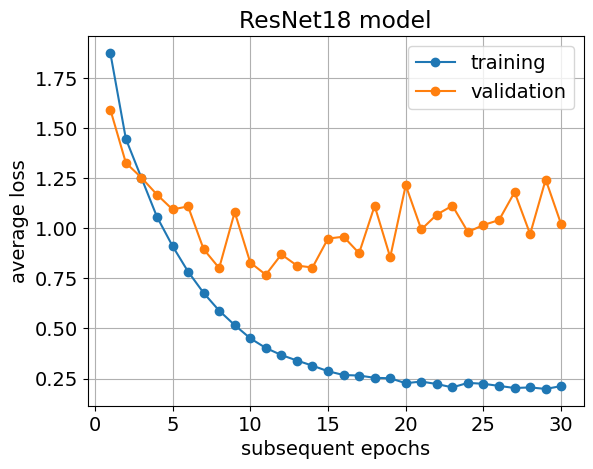

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet18().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']

train_loss, validation_loss, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
#plot_loss(train_loss, validation_loss, 'ResNet18 model')
plot_loss(torch.tensor(train_loss).cpu().numpy(), torch.tensor(validation_loss).cpu().numpy(), 'ResNet18 model')

Train Epoch: 1
	Train set: Average loss: 2.0019
	Validation set: Average loss: 1.7142, Accuracy: 1883/5000 (38%)
Train Epoch: 2
	Train set: Average loss: 1.5535
	Validation set: Average loss: 1.5076, Accuracy: 2240/5000 (45%)
Train Epoch: 3
	Train set: Average loss: 1.3958
	Validation set: Average loss: 1.3990, Accuracy: 2424/5000 (48%)
Train Epoch: 4
	Train set: Average loss: 1.2286
	Validation set: Average loss: 1.2648, Accuracy: 2690/5000 (54%)
Train Epoch: 5
	Train set: Average loss: 1.0807
	Validation set: Average loss: 1.1841, Accuracy: 2885/5000 (58%)
Train Epoch: 6
	Train set: Average loss: 0.9623
	Validation set: Average loss: 0.9389, Accuracy: 3342/5000 (67%)
Train Epoch: 7
	Train set: Average loss: 0.8183
	Validation set: Average loss: 1.0381, Accuracy: 3249/5000 (65%)
Train Epoch: 8
	Train set: Average loss: 0.7162
	Validation set: Average loss: 0.9033, Accuracy: 3410/5000 (68%)
Train Epoch: 9
	Train set: Average loss: 0.6283
	Validation set: Average loss: 0.8419, Accuracy:

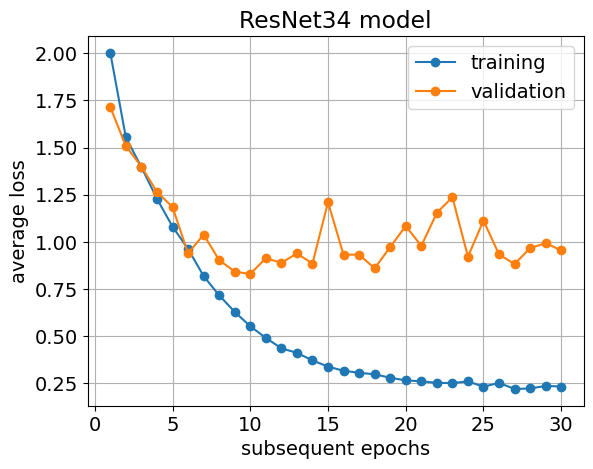

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet34().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'], 
                      momentum=model_args['momentum'],
                      weight_decay=1.e-3)

no_epochs = model_args['epochs']

train_loss34, validation_loss34, best_accuracy = run_training(model, criterion, optimizer, no_epochs)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
#plot_loss(train_loss34, validation_loss34, 'ResNet34 model')
plot_loss(torch.tensor(train_loss34).cpu().numpy(), torch.tensor(validation_loss34).cpu().numpy(), 'ResNet34 model')

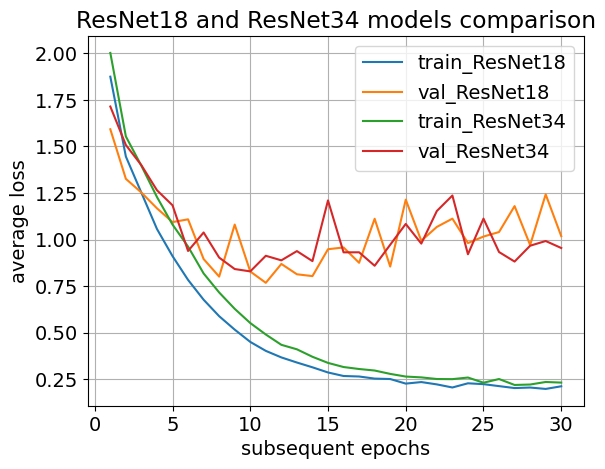

In [ ]:
plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
plt.plot(range(1, len(train_loss)+1), train_loss, label='train_ResNet18')
plt.plot(range(1, len(validation_loss)+1), torch.tensor(validation_loss).cpu().numpy(), label='val_ResNet18')
plt.plot(range(1, len(train_loss34)+1), train_loss34, label='train_ResNet34')
plt.plot(range(1, len(validation_loss34)+1), torch.tensor(validation_loss34).cpu().numpy(), label='val_ResNet34')
plt.legend()
plt.title("ResNet18 and ResNet34 models comparison")
plt.show()

### Tasks to do:

1. Check turning off the data normalization -- how this impacts network training.
2. What happens if we put *weight_decay* = 0. and increase *momentum* to .9 for VGG11 model -- why is that? (hint: obserwe interplay between *learning rate* and *momentum*)
3. Try to explain why the deeper VGG16 network trains longer than VGG11.
4. Compare with performance for deeper VGGs: 19 or 22 -- do we observe saturation in accuracy or even *degeradation* problem?
5. Does ResNet18 (with similar depth) performs better, what for ResNet34? What about training time in this case?
